!/usr/bin/env python3
 -*- coding: utf-8 -*-
"""
Created on Fri Dec  9 13:45:03 2022

@author: wslvivek
"""

#   MASTER
## Welcome to mat2py tool. This applies SH to process GRACE SH coefficients into Terrestrial water storage changes
#### Kindly provide the paths to respective files and outputs
#### 1. Reading SH coeffs from NASA JPL and replacing degree 1,2,3 coeffs'

In [1]:
path_sh_jpl = r"/home/wslvivek/Desktop/level2/master/input/"                      # Path to JPL GRACE data
path_tn14 = r"/home/wslvivek/Desktop/level2/master/TN_files/TN-14_C30_C20_GSFC_SLR.txt"    # Path to TN14
path_tn13 = r"/home/wslvivek/Desktop/level2/master/TN_files/TN-13_GEOC_JPL_RL06.txt"       # Path to TN13

In [2]:
import os
path_master = os.getcwd()                                            # current directory
path_functions = os.path.join(path_master,"Downscaling_mini")        # directory of the sh bundle functions
path_output = os.path.join(os.path.dirname(path_master),"output")    # directory for output

In [3]:
from reader_replacer import reader_replacer
from clm2sc import clm2sc
from scrpit import tws_cal
from basin_avg import basin_avg
import numpy as np
import pandas as pd
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

In [4]:
%%time
sh_clm, dates_start, dates_end, no_of_files = reader_replacer(path_sh_jpl, path_tn14, path_tn13)

Reading into clm format complete!
Number of files read: 142
Starting replacement
Degree 2,3 replacement complete!
Degree 1 replacement complete!
Number of months of data in each year starting 2002-04-04 & ending 2016-03-01 [ 7. 11.  8. 12. 12. 12. 12. 12. 12. 10.  7.  9.  9.  7.  2.  0.  0.  0.
  0.  0.  0.]
CPU times: user 2.98 s, sys: 109 ms, total: 3.09 s
Wall time: 3.09 s


* `sh_clm` is a ndarray containg lists of data: degree;  order; clm; slm; delta clm; delta slm; start data; end date*

#### 2. The following cells perform a bunch of operations


* Storing SH coeffs in clm format into SC format
* Calculation of delta clm & delta slm
* Application of Gaussian filter/filter of user choice
* Application of filter to delta clm, slm to get filtered SH coeffs
* Calling gshs() with filtered SH coeffs to obtain TWS fields
* Flipping the TWS fields to get 0 degree longitude in the middle
* Saving data in netCDF4 format and writing to disk

In [5]:
sc_mat_raw = clm2sc(sh_clm);
print('conversion clm to sc format complete!\n')

conversion clm to sc format complete!



In [6]:
print('Kindly enter the following parameters based on your application')
lmax = int(input("Enter lmax:"))
gs = int(input("Enter grid size"))
half_rad_gf = int(input("Enter half radius of Gaussian filter"))
print("lmax , grid size & half raduius of gaussian filter are : ", lmax ,", " , gs,", ",half_rad_gf)

Kindly enter the following parameters based on your application


Enter lmax: 40
Enter grid size 5
Enter half radius of Gaussian filter 500


lmax , grid size & half raduius of gaussian filter are :  40 ,  5 ,  500


In [8]:
lon = np.arange(-180,180,gs)
lat = np.arange(89,-91,-gs)
# dates = pd.to_datetime(pd.Series(dates_start), format='%Y-%m-%d').dt.strftime('%d-%m-%Y') \
#         + "    " \
#         +pd.to_datetime(pd.Series(dates_end), format='%Y-%m-%d').dt.strftime('%d-%m-%Y')
dates = pd.to_datetime(pd.Series(dates_start), format='%Y-%m-%d')#.dt.strftime('%d-%m-%Y')
print('dates read! \n')

dates read! 



##### Remove long term mean to get anomalies
* Long term mean is calculated from NASA JPL SH coeffs in the period 01-01-2005 & 31-12-2010 (6 years continuous)

In [9]:
SH_long_mean = np.load(path_master+'/SH_long_mean.npy')    # load the long term mean coeffs
sc_mat = sc_mat_raw - SH_long_mean

CPU times: user 1.62 s, sys: 5.01 ms, total: 1.62 s
Wall time: 1.62 s


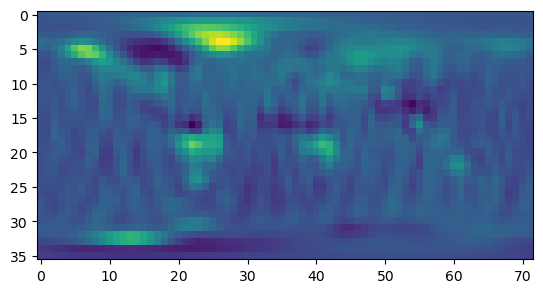

In [10]:
%%time
tws_fields = tws_cal(sc_mat,lmax,gs,half_rad_gf,no_of_files,path_functions)
tws_fields = np.float32(tws_fields)

In [11]:
ds = xr.Dataset(
    data_vars=dict(
        tws=(["time","lat", "lon"], tws_fields)
    ),
    coords = {
        "time":(('time'),dates),
        "lat":lat,
        "lon":lon },
    attrs=dict(description="TWS Anomaly corresponding to long term (2004-2010) mean \n lmax=96 and half radius of Gaussian filter = 500Km"),
)
ds

<xarray.Dataset>
Dimensions:  (time: 142, lat: 36, lon: 72)
Coordinates:
  * time     (time) datetime64[ns] 2002-04-04 2002-05-02 ... 2016-01-29
  * lat      (lat) int64 89 84 79 74 69 64 59 54 ... -56 -61 -66 -71 -76 -81 -86
  * lon      (lon) int64 -180 -175 -170 -165 -160 -155 ... 155 160 165 170 175
Data variables:
    tws      (time, lat, lon) float32 -12.11 -11.28 -10.3 ... 60.98 63.78 66.55
Attributes:
    description:  TWS Anomaly corresponding to long term (2004-2010) mean \n ...

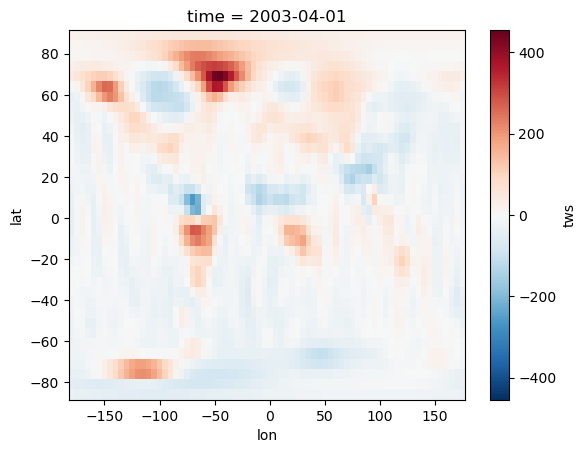

In [12]:
ds.tws.isel(time=10).plot()

In [13]:
ds.to_netcdf(str(path_output)+'/tws_mat2py.nc', engine="netcdf4")

### Basin averages

Do you want to calculate basin average?(y/n): y
Enter projected reference system: 32645


Area of basin in km2: 768353.6291053339


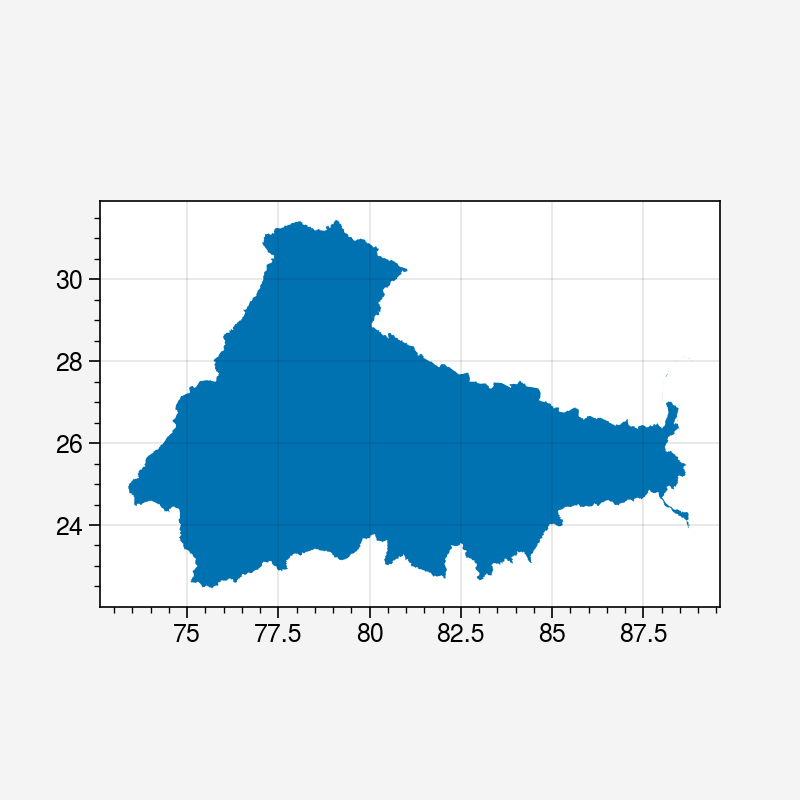

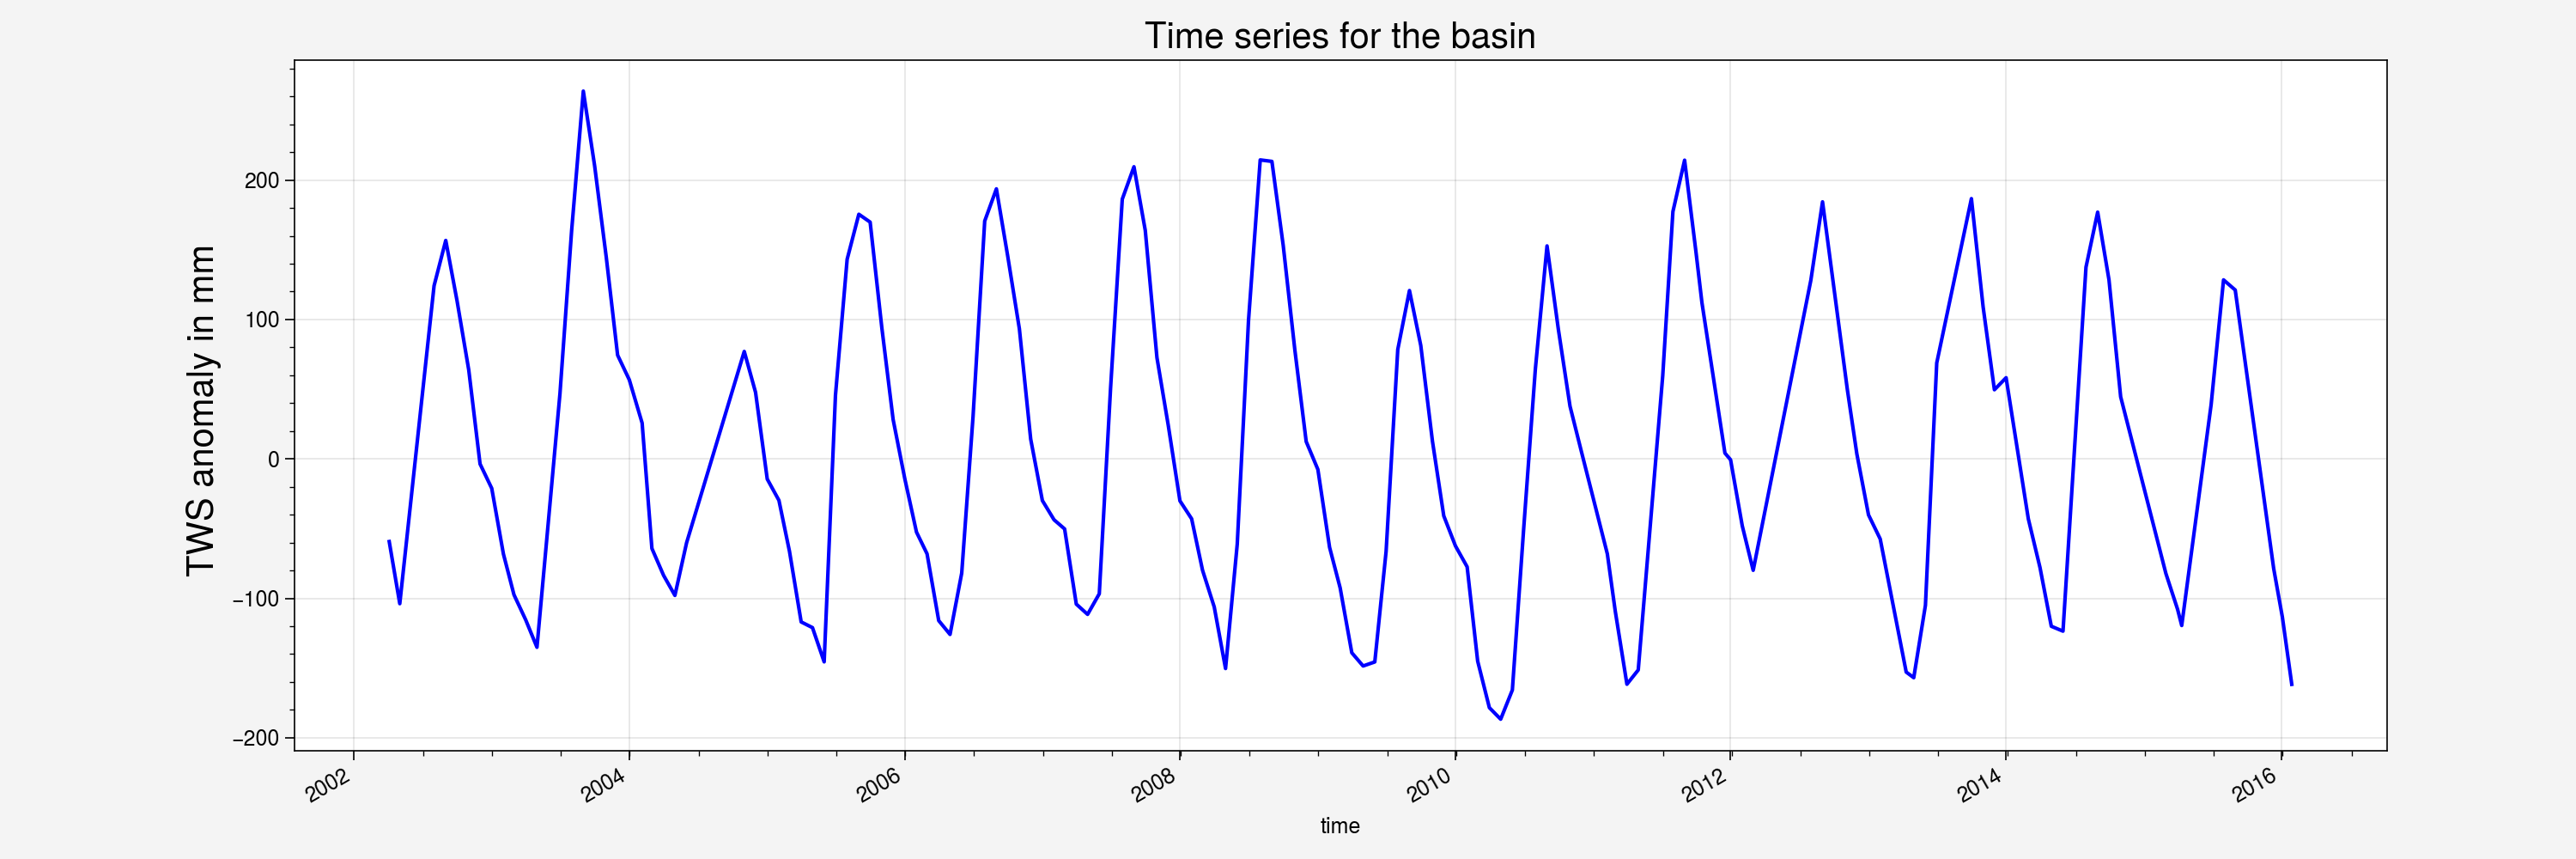

In [14]:
ans = str(input('Do you want to calculate basin average?(y/n):'))
if ans == 'y':
    path_shapefile = r"/home/wslvivek/Desktop/garca/vivek/Ganga.shp"
    c_rs = str(input('Enter projected reference system:'))
    tws_basin_avg = basin_avg(ds,path_shapefile,c_rs,no_of_files,gs)
else:
    pass
    

In [15]:
tws_basin_avg.to_netcdf(str(path_output)+'/tws_basin_avg.nc', engine="netcdf4")

In [ ]:
ds2 = xr.open_dataset('/home/wslvivek/Desktop/level2/preprocess/output/tws_mat2py.nc', engine="netcdf4")

In [ ]:
import hvplot.xarray
import panel.widgets as pnw

ds2.tws.interactive().sel(time=pnw.DiscreteSlider).plot #(color=Redblu)